<div dir=rtl align=center>

<img src='https://upload.wikimedia.org/wikipedia/fa/thumb/a/a9/Sharif_logo.svg/626px-Sharif_logo.svg.png?20110526112825' alt="SUT logo" width=200 height=200 align=center  >
<br>
<font face="B Yekan">
<font color=0F5298 size=7>
یادگیری ماشین<br>
<font color=2565AE size=5>
دانشکده مهندسی صنایع<br>
<font color=2565AE size=4>
دکتر مهدی شریف زاده <br>
<font  size=4>
امیرحسین محمودی <br>
بهار 1402<br>

<font color=3C99D size=5>
تشخیص لبخند لحظه ای<br>
    
    
    
____


# Part 1: training a classifier on the existing `faces` dataset

## Loading the `faces` dataset

We load the dataset using standard `sklearn` functions below.

In [2]:
%matplotlib inline
from pylab import *

In [3]:
!pip install opencv-python
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [109]:
from sklearn import datasets
faces = datasets.fetch_olivetti_faces()

The `faces` dataset consist of 400 images depicting 40 subjects in a variety of poses: open and closed eyes, smiling or not. The data can be accessed trough the keys below:

In [110]:
faces.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

One can plot a selection of images from the dataset.

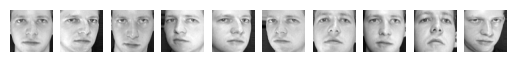

In [111]:
for i in range(10):
    face = faces.images[i]
    subplot(1, 10, i + 1)
    imshow(face.reshape((64, 64)), cmap='gray')
    axis('off')

## Producing the smile training data

Now that the dataset is loaded, we will build a cheap user interface to classify the 400 images into two categories:

- smiling face
- not smiling face

The class below stores the outcome of the user classification as a dictionary and is used to display the next image upon pressing a button from the GUI.

In [7]:
from ipywidgets import interact, Button
from IPython.display import display, clear_output

In [8]:
class Trainer:
    def __init__(self):
        self.results = {}
        self.imgs = faces.images
        self.index = 0
        
    def increment_face(self):
        if self.index + 1 >= len(self.imgs):
            return self.index
        else:
            while str(self.index) in self.results:
                print(self.index)
                self.index += 1
            return self.index
    
    def record_result(self, smile=True):
        self.results[str(self.index)] = smile

We first instantiate the class and then design a user interface using two buttons from the awesome `IPython.html.widgets` tools.

In [113]:
trainer = Trainer()

Button(description='smile', style=ButtonStyle())

Button(description='sad face', style=ButtonStyle())

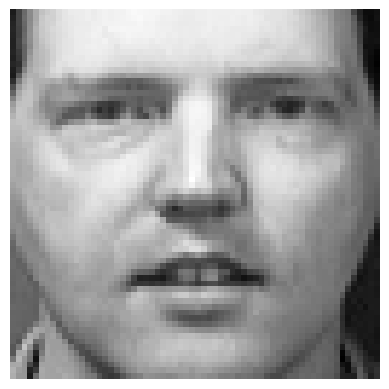

In [ ]:
button_smile = Button(description='smile')
button_no_smile = Button(description='sad face')

def display_face(face):
    clear_output()
    display(button_smile)
    display(button_no_smile)
    imshow(face, cmap='gray')
    axis('off')

def display_face2(face):
    clear_output()
    imshow(face, cmap='gray')
    axis('off')

def update_smile(b):
    trainer.record_result(smile=True)
    trainer.increment_face()
    display_face(trainer.imgs[trainer.index])

def update_no_smile(b):
    trainer.record_result(smile=False)
    trainer.increment_face()
    display_face(trainer.imgs[trainer.index])

button_no_smile.on_click(update_no_smile)
button_smile.on_click(update_smile)


display_face(trainer.imgs[trainer.index])

In [121]:
trainer.index

376

## Saving and loading the temporary results from the classification

Due to the fact that I classified the 400 faces over two sessions, I had to save the temporary results and reload them. This (and loading) is done in the lines below.

### Loading training dataset

In [116]:
import json

In [123]:
results = json.load(open('results.xml'))

In [124]:
trainer.results = results

### Saving training dataset

In [122]:
# with open('results.xml', 'w') as file:
#    json.dump(trainer.results, file)

## Visualizing the training set data

Now that our input data is ready, we can plot a little statistic from our dataset: how many people are smiling in the pictures and how many are not?

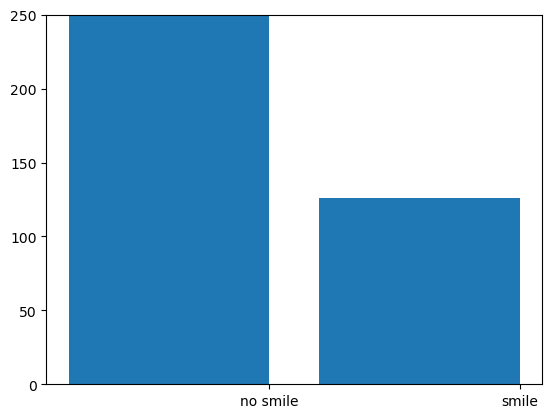

In [126]:
yes, no = (sum([trainer.results[x] == True for x in trainer.results]), 
            sum([trainer.results[x] == False for x in trainer.results]))
bar([0, 1], [no, yes])
ylim(0, max(yes, no))
xticks([0.4, 1.4], ['no smile', 'smile']);

Below, we're displaying the images of all the smiles and all the "non smiles" that we have classified.

In [127]:
smiling_indices = [int(i) for i in results if results[i] == True]

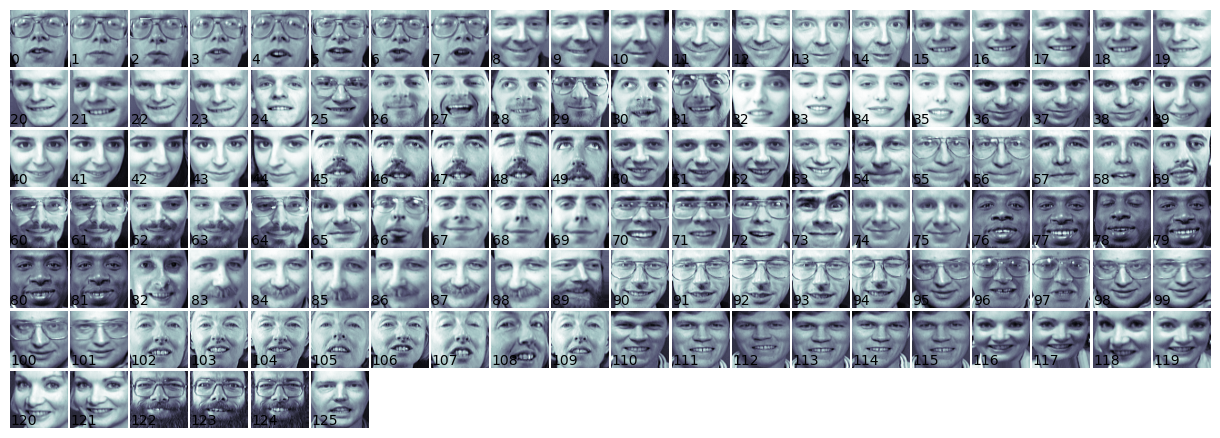

In [129]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(smiling_indices)):
    # plot the images in a matrix of 20x20
    p = fig.add_subplot(20, 20, i + 1)
    p.imshow(faces.images[smiling_indices[i]], cmap=plt.cm.bone)
    
    # label the image with the target value
   # p.text(0, 14, "smiling")
    p.text(0, 60, str(i))
    p.axis('off')

As you can see, some of the faces classified as smiling could be disagreed with. In fact, I often found myself confused while doing this task, because some of the images cannot be easily put into a smiling or non-smiling category in my opinion.

In [130]:
not_smiling_indices = [int(i) for i in results if results[i] == False]

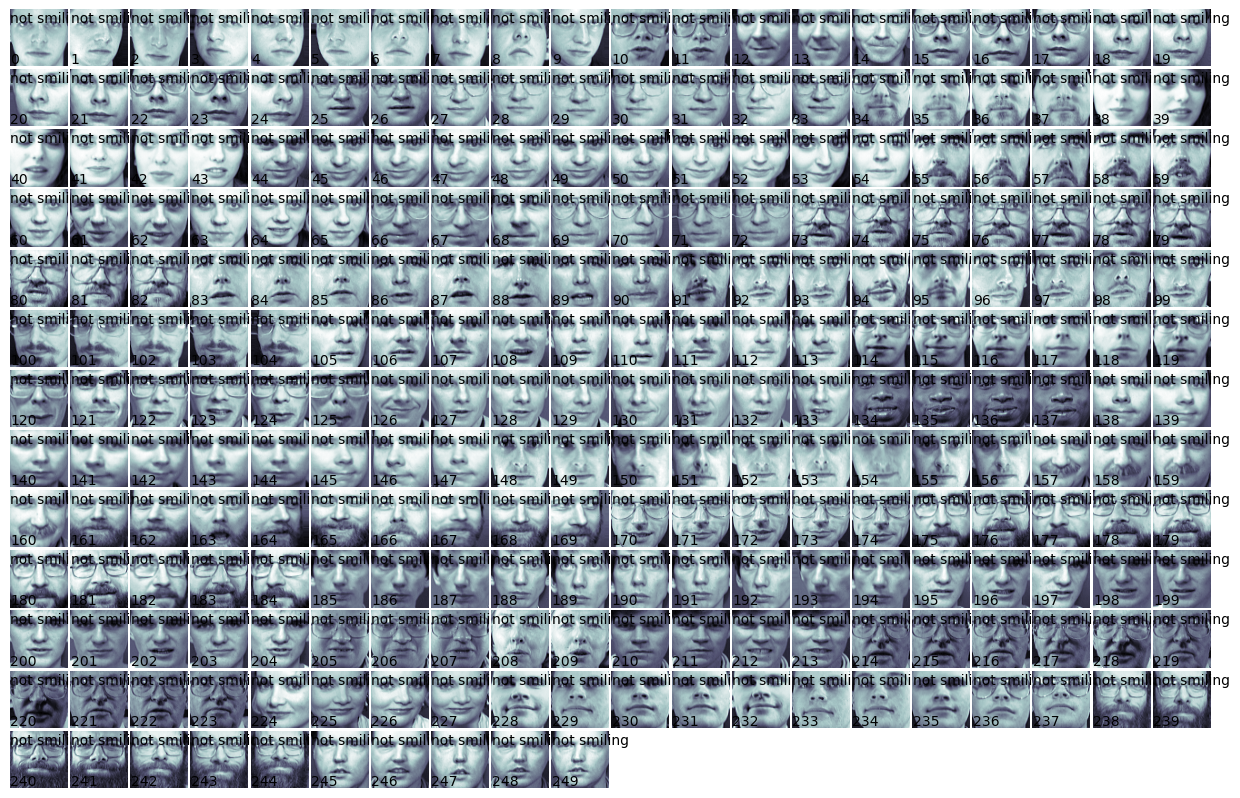

In [131]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(not_smiling_indices)):
    # plot the images in a matrix of 20x20
    p = fig.add_subplot(20, 20, i + 1)
    p.imshow(faces.images[not_smiling_indices[i]], cmap=plt.cm.bone)

    # label the image with the target value
    p.text(0, 14, "not smiling")
    p.text(0, 60, str(i))
    p.axis('off')

## Training the smile classifier

Now that we have our input data, we can train a machine learning model with it.
In the following, we use a support vector classifier to learn from the 400 smiles and non-smiles and predict the classification of a new image. 

First, we initialize the classifier with:

In [63]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')

We then build our dataset. First comes the image data:

In [135]:
indices = [int(i) for i in trainer.results]
data = faces.data[indices, :]

Then comes the target vector (in which a 1 stands for a smile and a 0 for a "non smile").

In [132]:
target = [trainer.results[i] for i in trainer.results]
target = array(target).astype(int32)

In [134]:
target.size

376

Finally, we train the classifier using 5 fold cross validation. I will not go into the details of this as I am not yet familiar enough with the subject.

In [24]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=0.25, random_state=0)

In [137]:
print(X_train.shape)

(282, 4096)


In [138]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold cross validation iterator
    cv = KFold( n_splits=K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print ("Mean score: {0:.3f} (+/-{1:.3f})".format(
        np.mean(scores), sem(scores)))

The trained classifier's performance is then evaluated:

In [139]:
evaluate_cross_validation(svc, X_train, y_train, 5)

[0.77192982 0.75438596 0.92857143 0.75       0.82142857]
Mean score: 0.805 (+/-0.033)


A mean score of approximately 0.8 is quite good. A further statistic is the confusion matrix that shows the errors that the classifier made during training.

In [140]:
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print ("Accuracy on training set:")
    print (clf.score(X_train, y_train))
    print ("Accuracy on testing set:")
    print (clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print ("Classification Report:")
    print (metrics.classification_report(y_test, y_pred))
    print ("Confusion Matrix:")
    print (metrics.confusion_matrix(y_test, y_pred))

In [141]:
train_and_evaluate(svc, X_train, X_test, y_train, y_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.8085106382978723
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        67
           1       0.66      0.70      0.68        27

    accuracy                           0.81        94
   macro avg       0.77      0.78      0.77        94
weighted avg       0.81      0.81      0.81        94

Confusion Matrix:
[[57 10]
 [ 8 19]]


## Testing the classifier on the training data

To check that our the trained machine learning classifier works, we again build a "cheap" GUI for displaying a face as well as the classifier prediction for this face.

this person is smiling: [False]


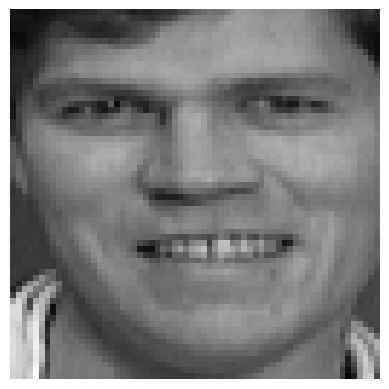

In [156]:
def display_face_and_prediction():
    index = randint(0, 400)
    face = faces.images[index]
    display_face2(face)
    print("this person is smiling: {0}".format(svc.predict(faces.data[index, :].reshape(1,-1))==1))


display_face_and_prediction()

As I am now convinced that this works reasonably well, we can now move on to the second part of this post: using OpenCV to capture an input and predict if the person is smiling or not.

# Part 2: face recognition and prediction using openCV

## Offline face recognition and smile prediction

In this section, we set up our algorithm to do the following things using still images of my face capture with the webcam (hence the name "offline"): 

- face detection on a supplied input image
- extraction of features from within the detected face; these features should have the same size than the ones that we used during the training of the SVC classifier above (i.e. 64x64 gray scale images)
- predicting if the detected person is smiling using the previously trained classifier

First, we import `cv2` and a test image.

In [94]:
import cv2

In [95]:
input_face = cv2.imread('pic.jpg')

Next, we use a [Haar cascade](http://docs.opencv.org/trunk/doc/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect a face in the input image. An XML file containing the cascade is read as an input for this.

In [157]:
cascPath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
gray = cv2.cvtColor(input_face, cv2.COLOR_BGR2GRAY)

detected_faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=6,
        minSize=(100, 100),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
detected_faces

array([[193,  33, 123, 123]])

A single faces was recognized. It is displayed with the original picture below:

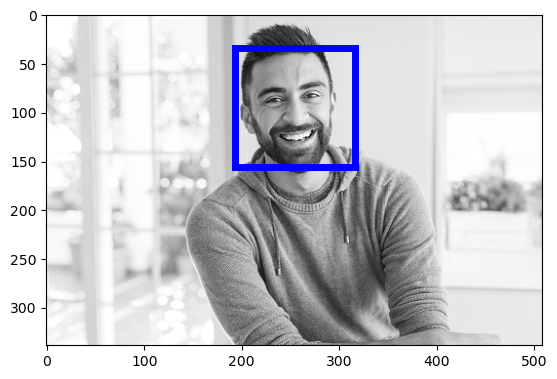

In [158]:
from matplotlib.patches import Rectangle
ax = gca()
ax.imshow(gray, cmap='gray')
for (x, y, w, h) in detected_faces:
    ax.add_artist(Rectangle((x, y), w, h, fill=False, lw=5, color='blue'))

We can now extract features from the face detected above to feed them to the SVC classifier. We do a little bit of stretching and cropping with arbitrarily set values to match the approximate format of the faces from the Olivetti dataset used to train the classifier.

In [159]:
original_extracted_face = gray[y:y+h, x:x+w]
horizontal_offset = 0.15 * w
vertical_offset = 0.2 * h
extracted_face = gray[int(y+vertical_offset):int(y+h), 
                      int(x+horizontal_offset):int(x-horizontal_offset+w)]

We can compare the extracted feature with the original face region returned by the Haar cascade.

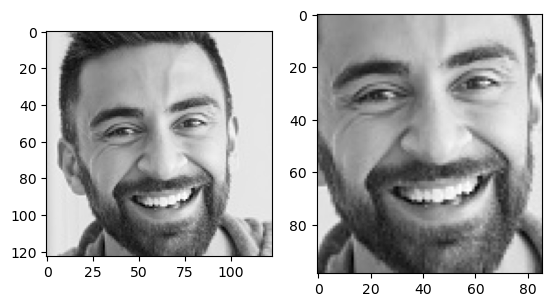

In [160]:
subplot(121)
imshow(original_extracted_face, cmap='gray')
subplot(122)
imshow(extracted_face, cmap='gray')

Finally, we transform the extracted image, that is approximately 200 times 200 pixels to a 64 times 64 image, so that it matches the feature format of the Olivetti dataset faces.

In [39]:
from scipy.ndimage import zoom

In [161]:
new_extracted_face = zoom(extracted_face, (64. / extracted_face.shape[0], 
                                           64. / extracted_face.shape[1]))

In [162]:
new_extracted_face = new_extracted_face.astype(float32)

In [42]:
new_extracted_face /= float(new_extracted_face.max())

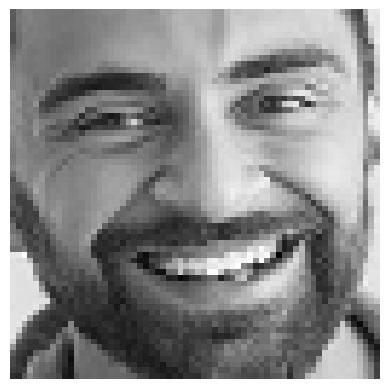

In [104]:
display_face2(new_extracted_face[:, :])

As you can see, my face has been a little stretched. Let's see if our classifier predicts that I'm smiling:

In [163]:
svc.predict(new_extracted_face.ravel().reshape(1,-1))

array([1])

It worked (because a 1 means a smile)! 

We can also check that the prediction step is very fast:

In [164]:
%timeit svc.predict(new_extracted_face.ravel().reshape(1,-1))

4.74 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's now write functions that automate the steps described above so that we can use them in a loop during live detection.

First, we rewrite the code for face detection. It uses a frame from the camera as input, converts it to grayscale and applies the Haar cascade to it. The detected faces and the gray images are then returned by the function.

In [46]:
def detect_face(frame):
    cascPath = "haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascPath)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=6,
            minSize=(100, 100),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
    return gray, detected_faces

Next, we write a function that extract features from a previously detected face in a gray image (hence its inputs). It also takes as arguments the horizontal and vertical stretch factors used to extract features for our classifier. Later on, we will decide on how to choose those coefficients using something else than luck.

In [165]:
def extract_face_features(gray, detected_face, offset_coefficients):
    (x, y, w, h) = detected_face
    horizontal_offset = offset_coefficients[0] * w
    vertical_offset = offset_coefficients[1] * h
    extracted_face = gray[int(y+vertical_offset):int(y+h), 
                      int(x+horizontal_offset):int(x-horizontal_offset+w)]
    new_extracted_face = zoom(extracted_face, (64. / extracted_face.shape[0], 
                                           64. / extracted_face.shape[1]))
    new_extracted_face = new_extracted_face.astype(float32)
    new_extracted_face /= float(new_extracted_face.max())
    return new_extracted_face

Finally, we define a function that predicts if an extracted face is smiling or not. This is basically just a wrapper call to the `predict` function of our SVC.

In [48]:
def predict_face_is_smiling(extracted_face):
    return svc.predict(extracted_face.ravel().reshape(1,-1))

## Live detection using the webcam

In [166]:
cascPath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    # detect faces
    gray, detected_faces = detect_face(frame)
    
    face_index = 0
    
    # predict output
    for face in detected_faces:
        (x, y, w, h) = face
        if w > 100:
            # draw rectangle around face 
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # extract features
            extracted_face = extract_face_features(gray, face, (0.03, 0.05)) #(0.075, 0.05)

            # predict smile
            prediction_result = predict_face_is_smiling(extracted_face)


            # annotate main image with a label
            if prediction_result == 1:
                cv2.putText(frame, "SMILING",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            else:
                cv2.putText(frame, "not smiling",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)

            # increment counter
            face_index += 1
                

    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

In [50]:
video_capture.release()
cv2.destroyAllWindows()